<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Seyed Morteza Seyedi
### Student ID: 98101771

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

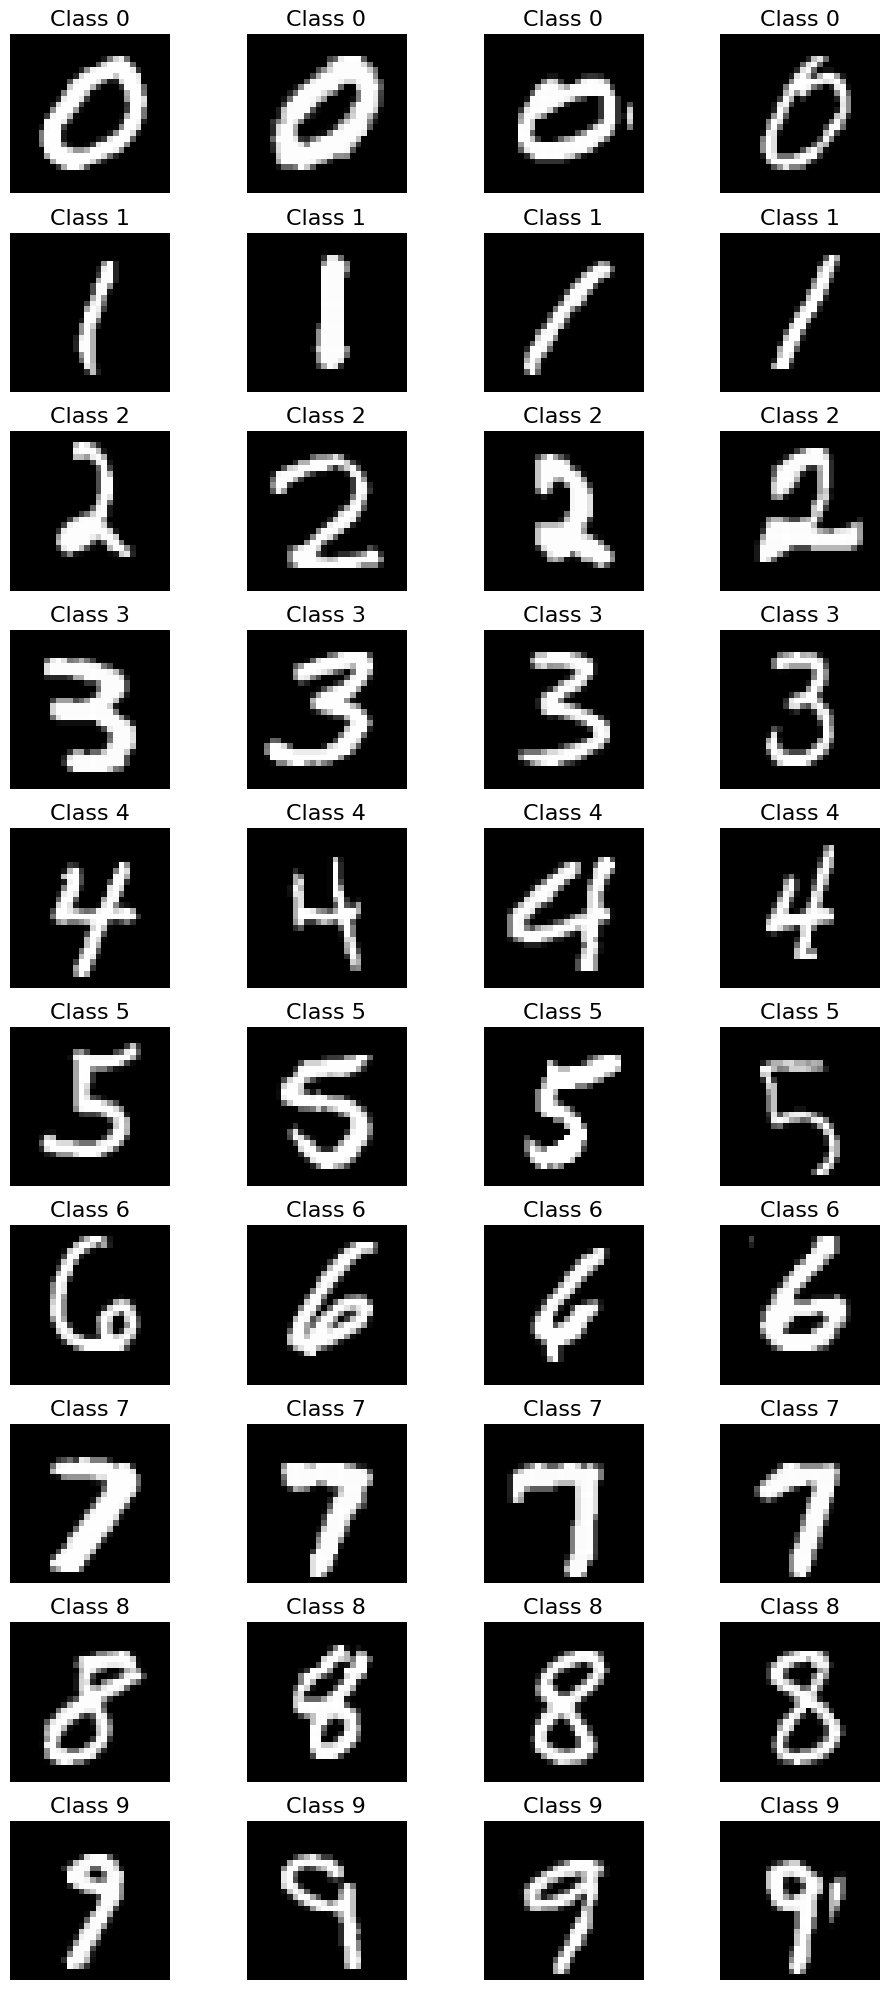

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [5]:
class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim[2], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim[2], latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim[2]),
            nn.ReLU(),
            nn.Linear(hidden_dim[2], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std         = torch.exp(0.5*logvar)
        st_normal   = torch.randn_like(std)
        return mu + st_normal*std

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.decoder(z)
        return x, mu, logvar

In [6]:
# Define VAE loss function
def vae_loss(recon, data, mu, logvar):
    reconstruction_loss = F.binary_cross_entropy(recon, data.view(-1, 28*28), reduction='sum')
    kl_divergence = 0.5 * torch.sum( logvar.exp() + mu.pow(2) - 1 - logvar )

    return (reconstruction_loss + kl_divergence) / data.shape[0]

In [7]:
# Training Loop - VAE (MLP)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)
            recon, mu, logvar = model(data)
            loss = vae_loss(recon, data, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss = total_loss + loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = sample.to(device)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/20], Loss: 2.906167475382487
Sample Images:


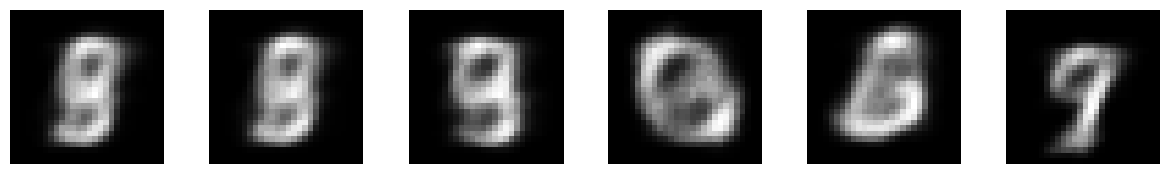


##################################################
VAE-MLP Epoch [2/20], Loss: 2.500500709279378
Sample Images:


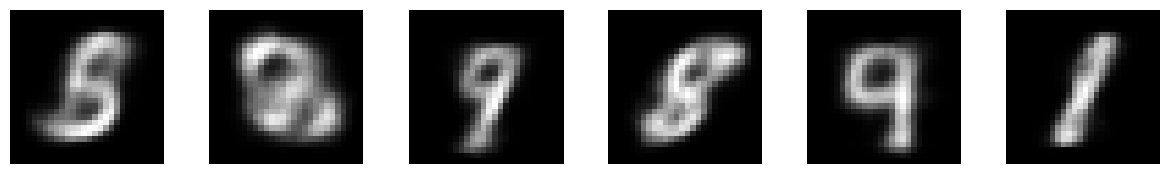


##################################################
VAE-MLP Epoch [3/20], Loss: 2.402830783843994
Sample Images:


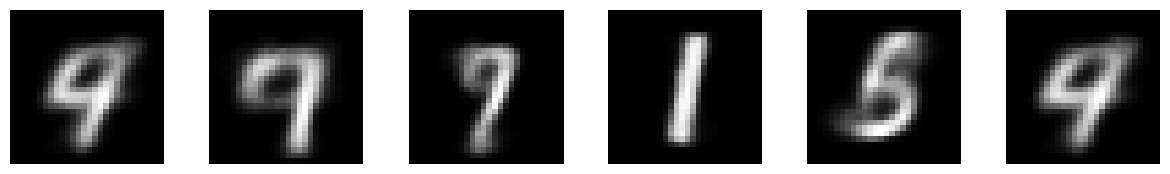


##################################################
VAE-MLP Epoch [4/20], Loss: 2.343007731374105
Sample Images:


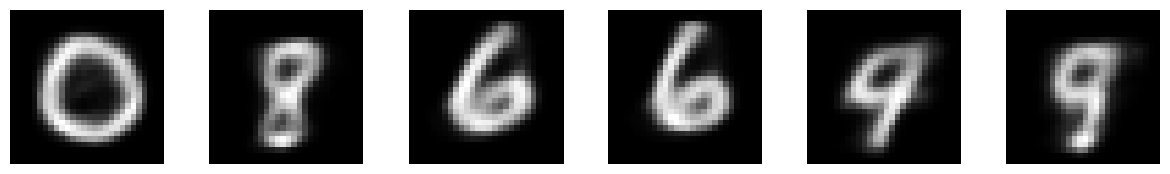


##################################################
VAE-MLP Epoch [5/20], Loss: 2.3026901383717853
Sample Images:


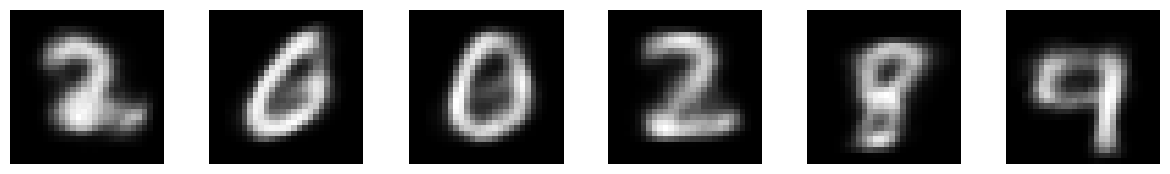


##################################################
VAE-MLP Epoch [6/20], Loss: 2.275220757039388
Sample Images:


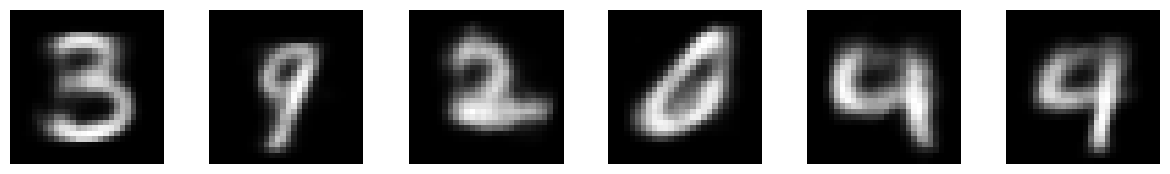


##################################################
VAE-MLP Epoch [7/20], Loss: 2.255275152206421
Sample Images:


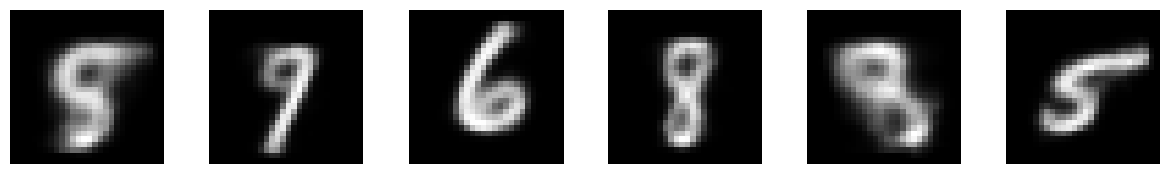


##################################################
VAE-MLP Epoch [8/20], Loss: 2.2428780475616454
Sample Images:


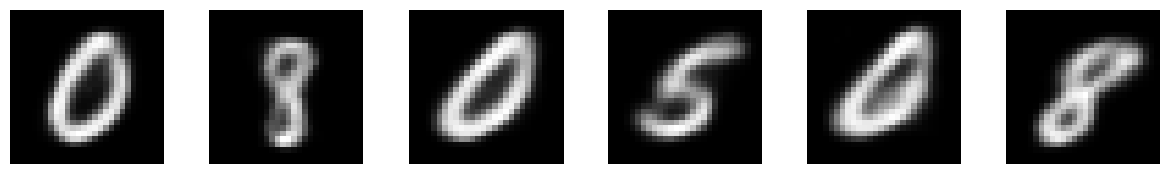


##################################################
VAE-MLP Epoch [9/20], Loss: 2.2281237222035726
Sample Images:


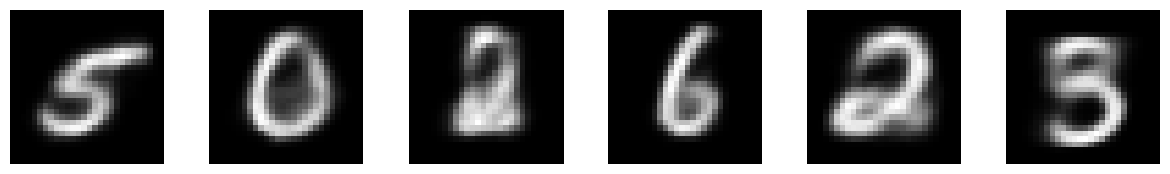


##################################################
VAE-MLP Epoch [10/20], Loss: 2.2189276082356773
Sample Images:


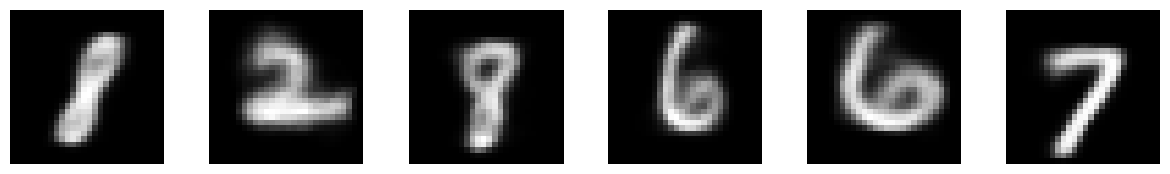


##################################################
VAE-MLP Epoch [11/20], Loss: 2.2130628611246745
Sample Images:


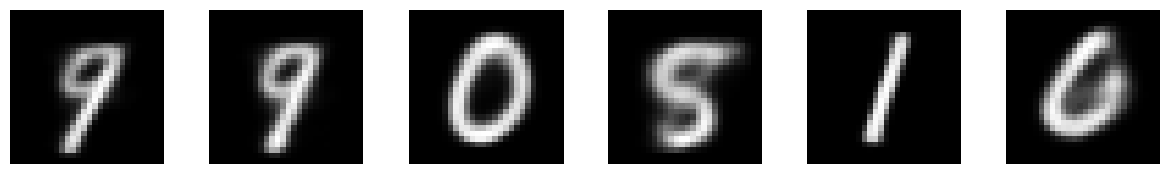


##################################################
VAE-MLP Epoch [12/20], Loss: 2.205277159118652
Sample Images:


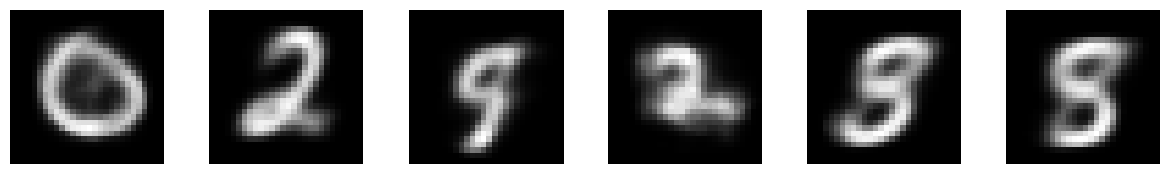


##################################################
VAE-MLP Epoch [13/20], Loss: 2.2004401788075767
Sample Images:


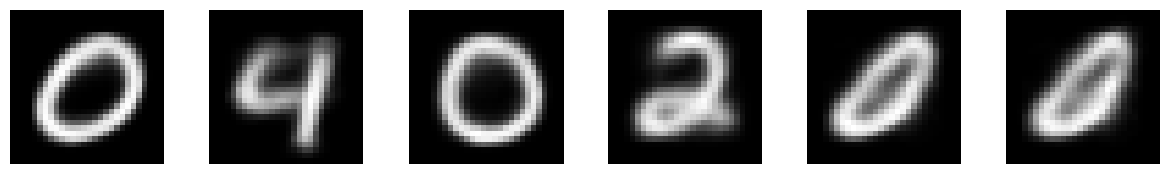


##################################################
VAE-MLP Epoch [14/20], Loss: 2.193470163726807
Sample Images:


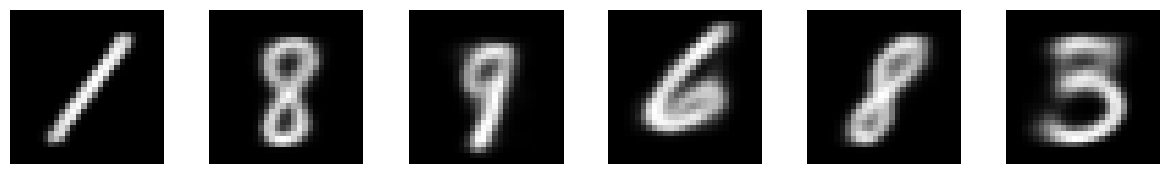


##################################################
VAE-MLP Epoch [15/20], Loss: 2.1887298071543375
Sample Images:


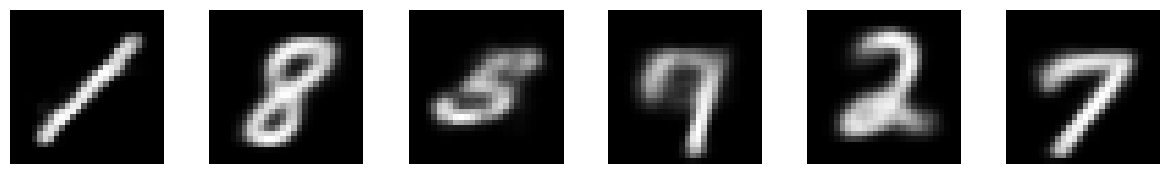


##################################################
VAE-MLP Epoch [16/20], Loss: 2.1908354305267332
Sample Images:


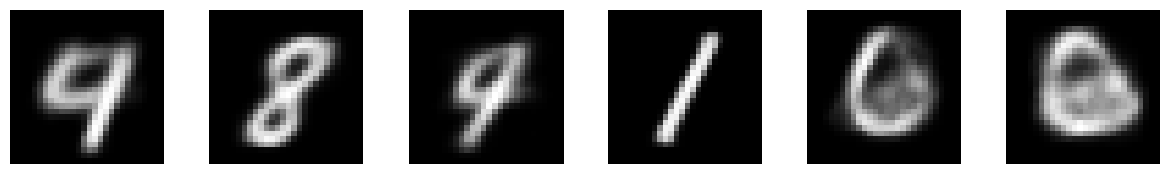


##################################################
VAE-MLP Epoch [17/20], Loss: 2.1827656092325847
Sample Images:


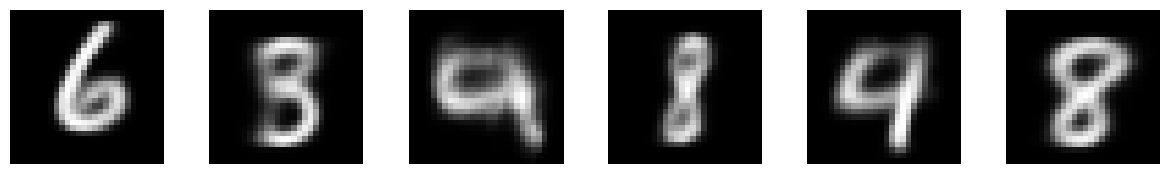


##################################################
VAE-MLP Epoch [18/20], Loss: 2.180031845855713
Sample Images:


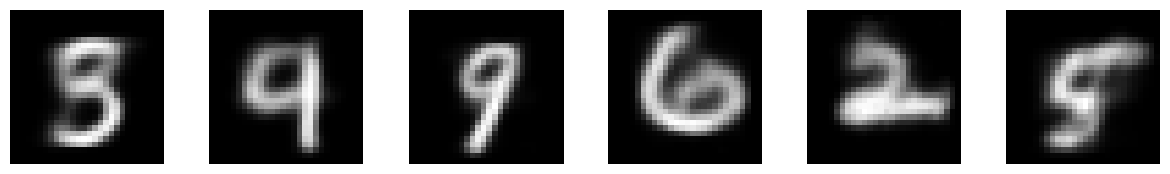


##################################################
VAE-MLP Epoch [19/20], Loss: 2.175305122121175
Sample Images:


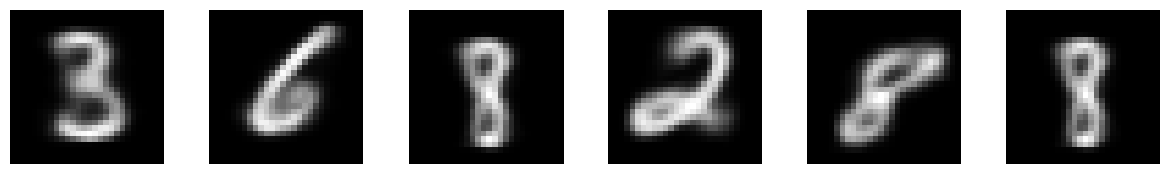


##################################################
VAE-MLP Epoch [20/20], Loss: 2.177625988006592
Sample Images:


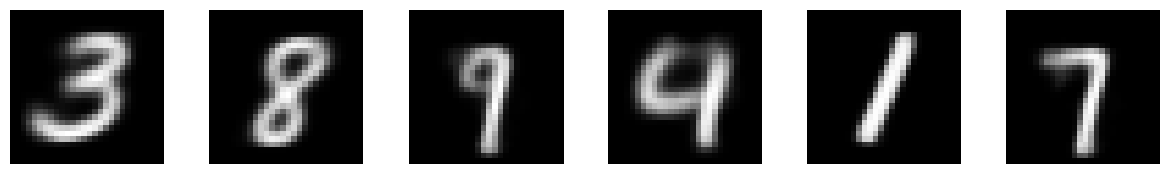

Best model saved as 'best_vae_mlp_model.pth'


In [8]:
# Train VAE-MLP
vae_mlp = VAE_MLP(28*28, [256, 128, 64], 2).to(device)
train_vae_mlp(vae_mlp, train_loader, num_epochs=20, learning_rate=1e-3)

# 2) CVAE --> MLP

In [9]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim[2], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim[2], latent_dim)
        self.fc_class = nn.Linear(hidden_dim[2], num_classes)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim[2]),
            nn.ReLU(),
            nn.Linear(hidden_dim[2], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std         = torch.exp(0.5*logvar)
        st_normal   = torch.randn_like(std)
        return mu + st_normal*std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        x = torch.cat([x, y], dim=1)

        hidden          = self.encoder(x)
        mu              = self.fc_mu(hidden)
        logvar          = self.fc_logvar(hidden)
        z               = self.reparameterize(mu, logvar)
        # class_logits    = self.fc_class(hidden)
        reconstructed = self.decoder(torch.cat([z, y], dim=1))

        return reconstructed, mu, logvar


In [10]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar):
    reconstruction_loss = F.binary_cross_entropy(recon, data.view(-1, 28*28), reduction='sum')
    kl_divergence = 0.5 * torch.sum( logvar.exp() + mu.pow(2) - 1 - logvar )
    # ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    return (reconstruction_loss + kl_divergence) / data.shape[0]


In [11]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            labels_one_hot = F.one_hot(labels, num_classes=10).float()
            data = data.to(device)
            labels_one_hot = labels_one_hot.to(device)
            recon, mu, logvar = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss = total_loss + loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = sample.to(device)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################


CVAE-MLP Epoch [1/20], Loss: 2.648543487294515
Sample Images:


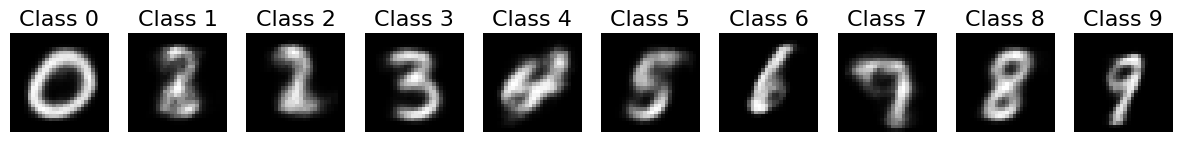


##################################################
CVAE-MLP Epoch [2/20], Loss: 2.1828733505249023
Sample Images:


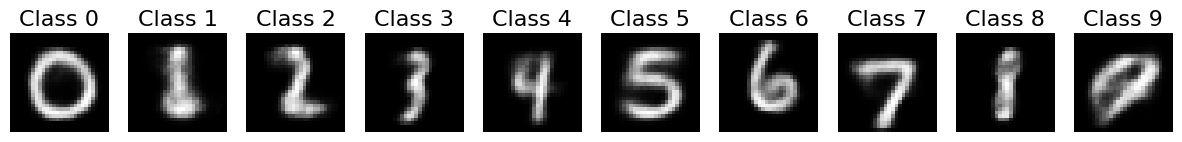


##################################################
CVAE-MLP Epoch [3/20], Loss: 2.1231620887756346
Sample Images:


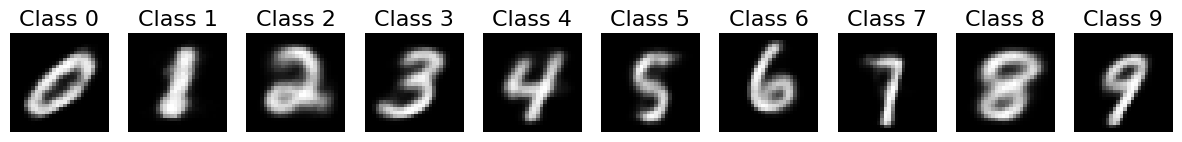


##################################################
CVAE-MLP Epoch [4/20], Loss: 2.0938601294199626
Sample Images:


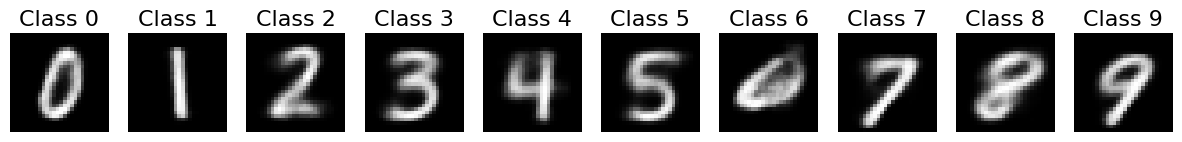


##################################################
CVAE-MLP Epoch [5/20], Loss: 2.076424733352661
Sample Images:


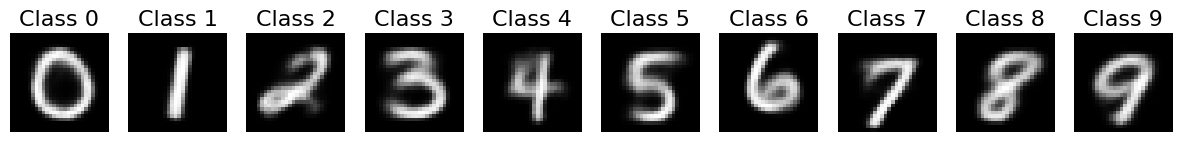


##################################################
CVAE-MLP Epoch [6/20], Loss: 2.0636752512613934
Sample Images:


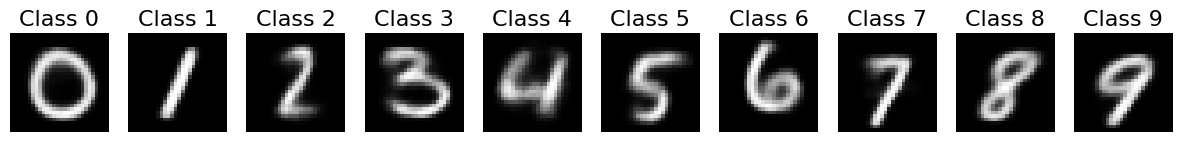


##################################################
CVAE-MLP Epoch [7/20], Loss: 2.055041268793742
Sample Images:


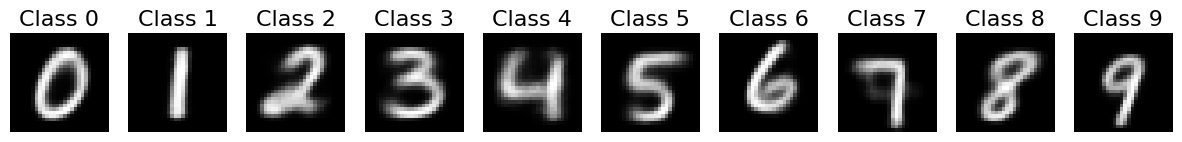


##################################################
CVAE-MLP Epoch [8/20], Loss: 2.04663509165446
Sample Images:


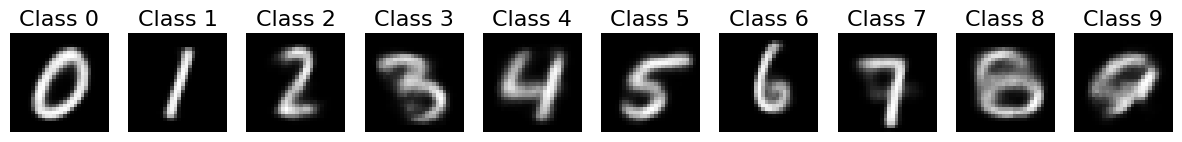


##################################################
CVAE-MLP Epoch [9/20], Loss: 2.0408131383260093
Sample Images:


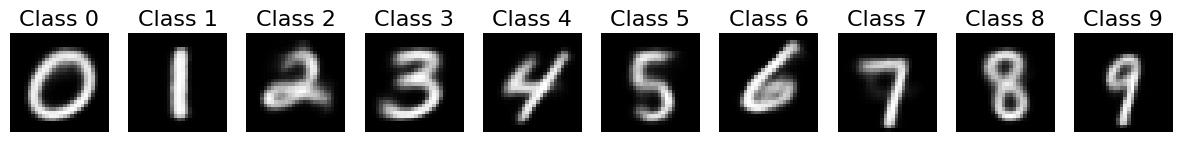


##################################################
CVAE-MLP Epoch [10/20], Loss: 2.0346188652038575
Sample Images:


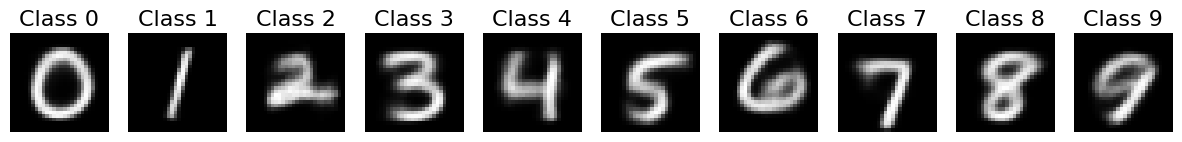


##################################################
CVAE-MLP Epoch [11/20], Loss: 2.0302563297271727
Sample Images:


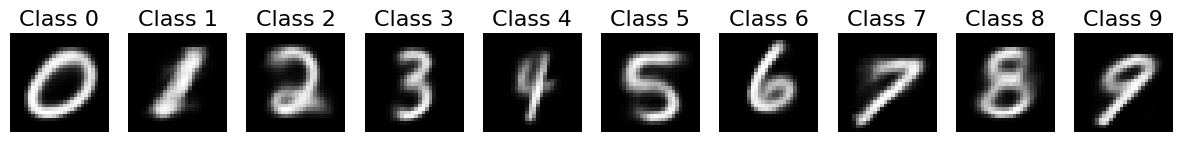


##################################################
CVAE-MLP Epoch [12/20], Loss: 2.024651783498128
Sample Images:


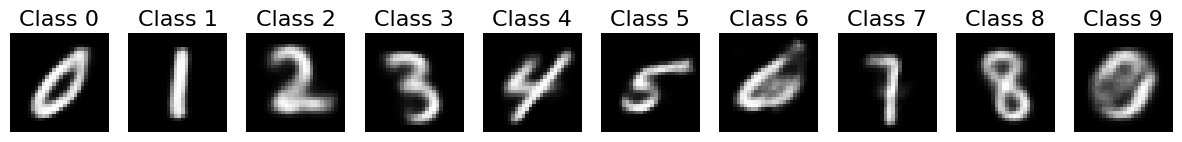


##################################################
CVAE-MLP Epoch [13/20], Loss: 2.0214234813690184
Sample Images:


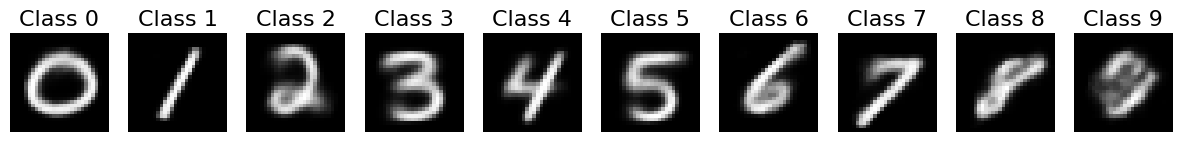


##################################################
CVAE-MLP Epoch [14/20], Loss: 2.0169045059204103
Sample Images:


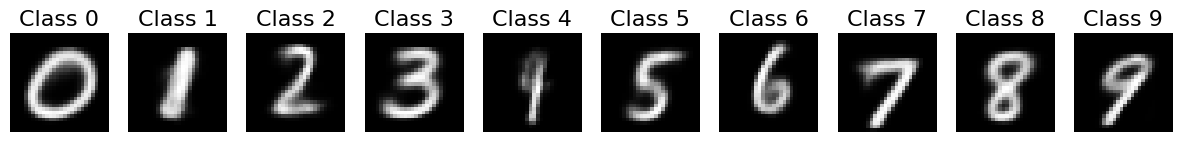


##################################################
CVAE-MLP Epoch [15/20], Loss: 2.0155130443573
Sample Images:


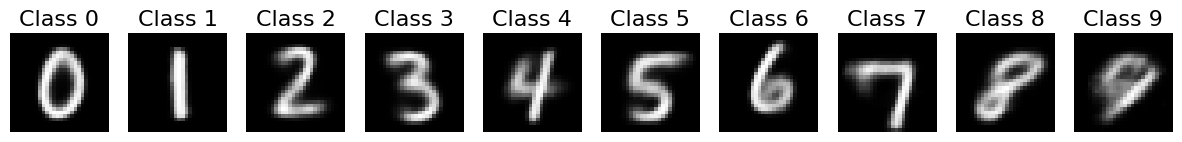


##################################################
CVAE-MLP Epoch [16/20], Loss: 2.012757925415039
Sample Images:


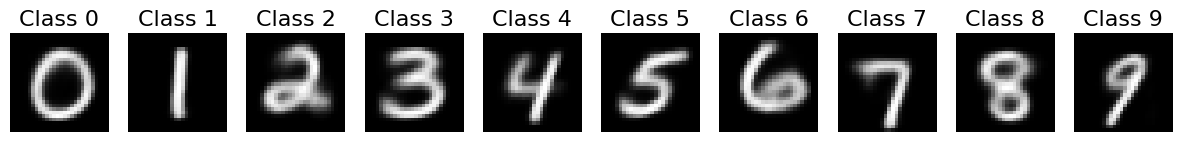


##################################################
CVAE-MLP Epoch [17/20], Loss: 2.008418960952759
Sample Images:


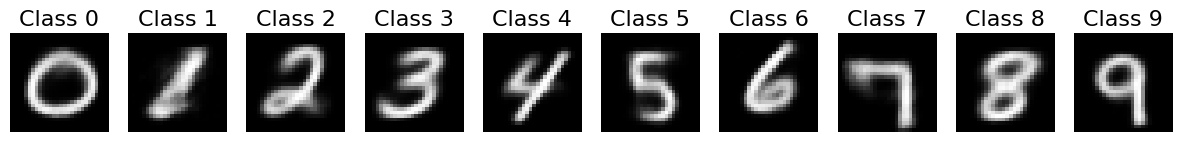


##################################################
CVAE-MLP Epoch [18/20], Loss: 2.004526904042562
Sample Images:


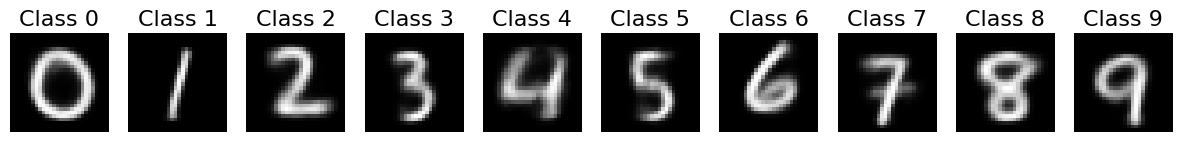


##################################################
CVAE-MLP Epoch [19/20], Loss: 2.0023851188659667
Sample Images:


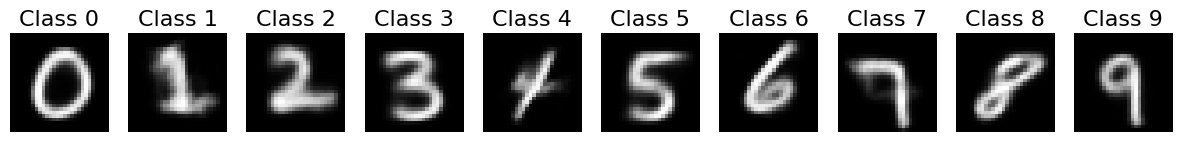


##################################################
CVAE-MLP Epoch [20/20], Loss: 1.999573783493042
Sample Images:


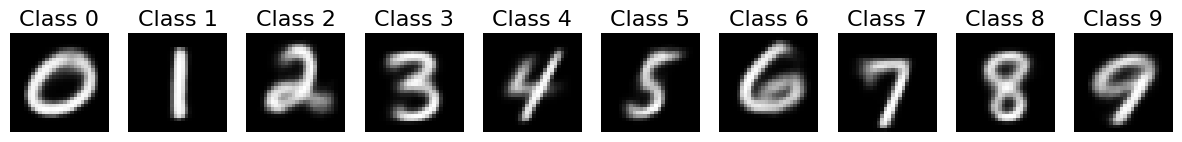

Best model saved as 'best_cvae_mlp_model.pth'


In [12]:
cvae_mlp = CVAE_MLP(28*28, [256, 128, 64], 2, 10).to(device)
train_cvae_mlp(cvae_mlp, train_loader, num_epochs=20, learning_rate=1e-3)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


In [13]:
model_VAE = VAE_MLP(28*28, [256, 128, 64], 2).to(device)
model_VAE.load_state_dict(torch.load('best_vae_mlp_model.pth'))

model_CVAE = CVAE_MLP(28*28, [256, 128, 64], 2, 10).to(device)
model_CVAE.load_state_dict(torch.load('best_cvae_mlp_model.pth'))

transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset, batch_size=64, shuffle=True)

def plot_latent_space(model, model_type, test_loader, device):
    model.eval()
    latent_space = []
    labels = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data = data.to(device)
            if model_type == 'CVAE':
                _, mu, logvar = model(data, F.one_hot(label, num_classes=10).float().to(device))
            else:
                _, mu, logvar = model(data)
            z = model.reparameterize(mu, logvar)
            latent_space.append(z)
            labels.append(label)
    latent_space = torch.cat(latent_space).cpu()
    labels = torch.cat(labels).cpu()
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_space[:, 0], latent_space[:, 1], c=labels, cmap='rainbow')
    plt.colorbar()
    plt.show()

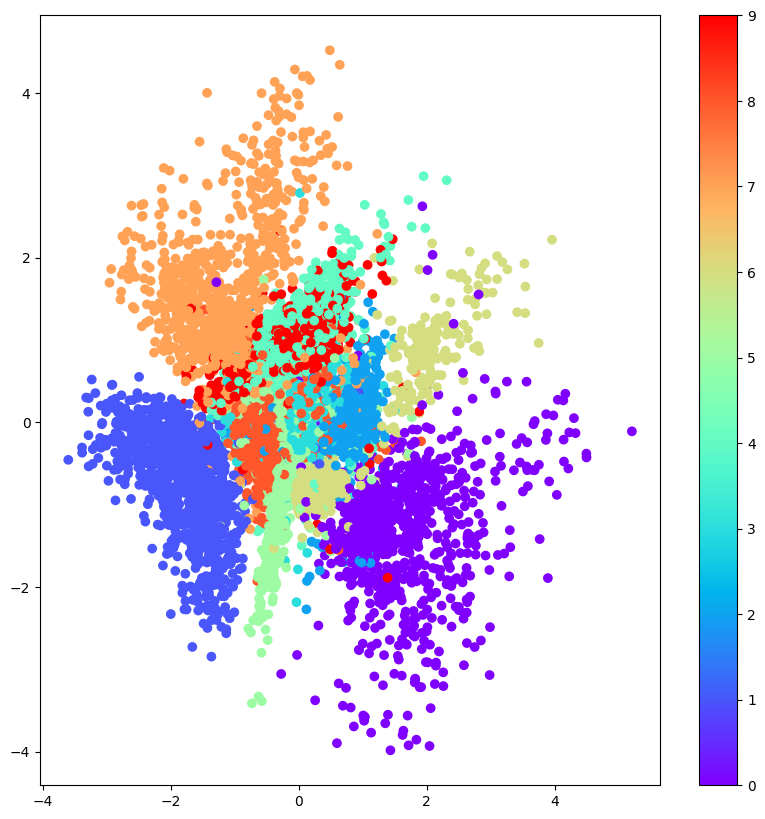

In [14]:
# plot latent space for VAE
plot_latent_space(model_VAE, 'VAE', test_loader, device)

<div dir="rtl">
<font face="B Nazanin" size="5">

همان طور که انتظار داریم اعداد 0 تا 9 مجموعا در توزیع دو بعدی نرمال با میانگین صفر و واریانس 1 قرار گرفته اند، اما چون لیبل ها را به شبکه نداده ایم هر کدام از عدد ها به قسمت خاصی از توزیع مپ شده اند

</font>
</div>

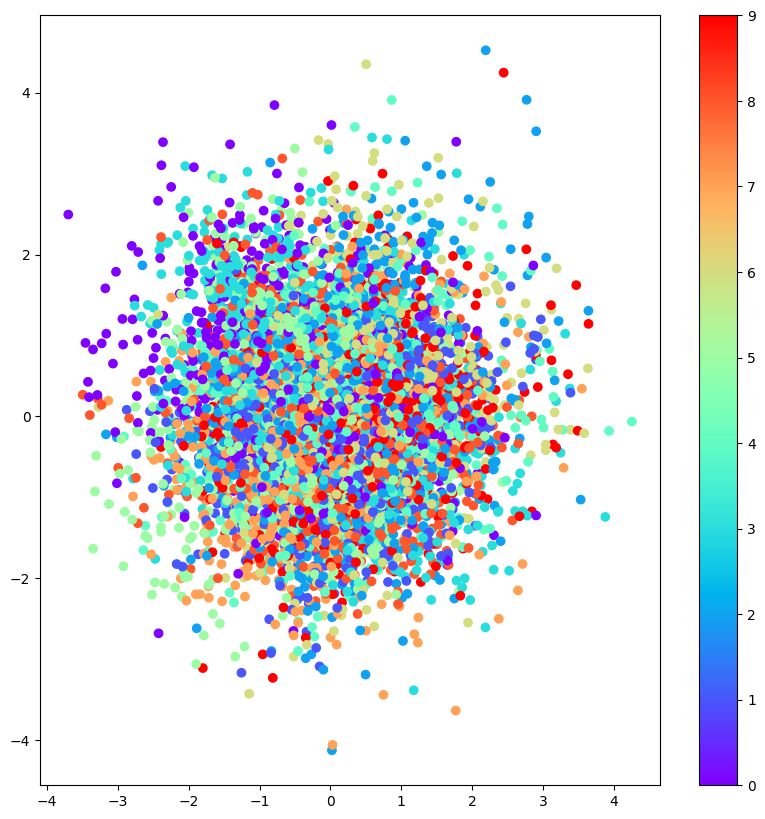

In [15]:
# plot latent space for VAE
plot_latent_space(model_CVAE, 'CVAE', test_loader, device)

<div dir="rtl">
<font face="B Nazanin" size="5">

در این قسمت هم طبق انتظار ما اعداد به توزیع نرمال با میانگین صفر و واریانس یک مپ شده اند اما چون کاندیشن یا لیبل هم به شبکه داده شده است ، شبکه برای هر عدد یک توزیع نرمال جدا با میانگین صفر و واریانس یک ساخته است واعداد مانند قسمت قبل به قسمتی خاص از توزیع مپ نشده اند 
</font>
</div>